<a href="https://colab.research.google.com/github/arumishra/Bachelor-Thesis-Project/blob/main/btpworkl_shapedgrid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np

In [2]:
import pandas as pd

In [3]:
df=pd.read_csv('/content/b5.csv')

In [4]:
df

,x,y,u,v,p,totime
0,0.4,10.0,1.0001,-0.0006,0.0135,252.999
1,1.0,10.0,1.0002,-0.0014,0.0134,252.999
2,1.6,10.0,1.0005,-0.0023,0.0132,252.999
3,2.2,10.0,1.0008,-0.0031,0.0129,252.999
4,2.8,10.0,1.0011,-0.0039,0.0125,252.999
...,...,...,...,...,...,...
1029345,39.2,30.0,1.0138,0.0005,0.0064,256.999
1029346,39.4,30.0,1.0138,0.0005,0.0064,256.999
1029347,39.6,30.0,1.0138,0.0005,0.0064,256.999
1029348,39.8,30.0,1.0139,0.0004,0.0065,256.999


In [5]:
import pandas as pd
df=pd.read_csv('/content/b5.csv')
X_cut=0.5
Y_cut=0.5
df_L_shape=df[(df["x"]>X_cut) | (df["y"]>Y_cut)]


In [6]:
import pandas as pd

# Load the CSV file
#df = pd.read_csv('your_grid.csv')  # Replace with your actual file path

# Get unique x and y values
unique_x = sorted(df['x'].unique())
unique_y = sorted(df['y'].unique())

# Dimensions
num_x = len(unique_x)
num_y = len(unique_y)

print(f"Number of unique x-values: {num_x}")
print(f"Number of unique y-values: {num_y}")
print(f"Grid shape: ({num_y}, {num_x}) → {num_y} rows (y), {num_x} columns (x)")


Number of unique x-values: 714
Number of unique y-values: 519
Grid shape: (519, 714) → 519 rows (y), 714 columns (x)


In [7]:
import pandas as pd

# Load your CSV file
#df = pd.read_csv('your_grid.csv')  # Replace with actual file path

# Get min and max of x and y
x_min = df['x'].min()
x_max = df['x'].max()
y_min = df['y'].min()
y_max = df['y'].max()

print(f"x_min: {x_min}, x_max: {x_max}")
print(f"y_min: {y_min}, y_max: {y_max}")


x_min: 0.0, x_max: 40.0
y_min: 10.0, y_max: 30.0


In [8]:
import pandas as pd

# Load the CSV
#df = pd.read_csv('your_grid.csv')

# Set thickness in real units
vertical_thickness = 3.0  # in x-direction
horizontal_thickness = 3.0  # in y-direction

# Get min values
x_min = df['x'].min()
y_min = df['y'].min()

# Mask for thick vertical arm: x ∈ [x_min, x_min + vertical_thickness]
vertical_mask = (df['x'] >= x_min) & (df['x'] <= x_min + vertical_thickness)

# Mask for thick horizontal arm: y ∈ [y_min, y_min + horizontal_thickness]
horizontal_mask = (df['y'] >= y_min) & (df['y'] <= y_min + horizontal_thickness)

# Combine both to get L-shape
l_mask = vertical_mask | horizontal_mask
df_l_shape = df[l_mask].copy()


In [9]:
print(f"Original grid size: {df.shape[0]}")
print(f"L-shaped grid size: {df_l_shape.shape[0]}")


Original grid size: 1029350
L-shaped grid size: 52755


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


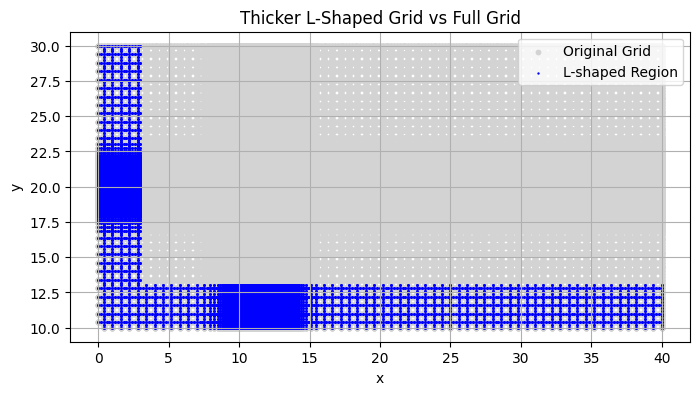

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV
#df = pd.read_csv('your_grid.csv')

# Define thickness (in coordinate units)
vertical_thickness = 3.0  # thickness of the vertical arm in x-direction
horizontal_thickness = 3.0  # thickness of the horizontal arm in y-direction

# Get bounding box
x_min = df['x'].min()
y_min = df['y'].min()

# Create masks
vertical_mask = (df['x'] >= x_min) & (df['x'] <= x_min + vertical_thickness)
horizontal_mask = (df['y'] >= y_min) & (df['y'] <= y_min + horizontal_thickness)

l_mask = vertical_mask | horizontal_mask
df_l_shape = df[l_mask].copy()

# Plot full grid (gray)
plt.figure(figsize=(8, 6))
plt.scatter(df['x'], df['y'], color='lightgray', s=10, label='Original Grid')

# Overlay L-shaped region (blue)
plt.scatter(df_l_shape['x'], df_l_shape['y'], color='blue', s=0.5, label='L-shaped Region')

# Grid styling
plt.gca().set_aspect('equal', adjustable='box')
plt.title('Thicker L-Shaped Grid vs Full Grid')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()


In [11]:
count=(df_l_shape['totime']==253.999).sum()
count

np.int64(10551)

In [12]:
data=df_l_shape

In [13]:
import tensorflow as tf
from tensorflow.keras import layers

class SpatioTemporalTransformer(tf.keras.Model):
    def __init__(self, input_dim=3, output_dim=3, d_model=128, num_heads=8, num_layers=6, ff_dim=512, dropout_rate=0.1):
        super(SpatioTemporalTransformer, self).__init__()

        # Input projection: project input (t, x, y) to d_model dimension
        self.input_projection = layers.Dense(d_model)

        # Positional encoding
        self.positional_encoding = PositionalEncoding(d_model)

        # Transformer layers
        self.encoder_layers = [TransformerEncoderLayer(d_model, num_heads, ff_dim, dropout_rate) for _ in range(num_layers)]

        # Output projection: project transformer output to (u, v, p)
        self.output_projection = layers.Dense(output_dim)

    def call(self, inputs):
        """
        Forward pass for the transformer model.
        Args:
        - inputs: Tensor of shape (batch_size, seq_len, input_dim) -> (t, x, y)

        Returns:
        - output: Tensor of shape (batch_size, seq_len, output_dim) -> (u, v, p)
        """
        # Apply input projection
        x = self.input_projection(inputs)

        # Apply positional encoding
        x = self.positional_encoding(x)

        # Forward through transformer encoder layers
        for layer in self.encoder_layers:
            x = layer(x)

        # Output projection to (u, v, p)
        output = self.output_projection(x)

        return output

class PositionalEncoding(layers.Layer):
    def __init__(self, d_model, max_len=7000):
        super(PositionalEncoding, self).__init__()
        self.d_model = d_model

        # Create the positional encoding matrix using sine and cosine
        position = tf.range(max_len, dtype=tf.float32)[:, tf.newaxis]
        div_term = tf.exp(tf.range(0, d_model, 2, dtype=tf.float32) * (-tf.math.log(10000.0) / d_model))

        pe_sin = tf.sin(position * div_term)
        pe_cos = tf.cos(position * div_term)

        # Concatenate sine and cosine terms along the last dimension
        pe = tf.concat([pe_sin, pe_cos], axis=-1)

        # Add an extra batch dimension at the start, so shape becomes (1, max_len, d_model)
        pe = tf.expand_dims(pe, 0)
        self.positional_encoding = tf.Variable(pe, trainable=False)

    def call(self, x):
        """
        Forward pass for positional encoding.
        Args:
        - x: Tensor of shape (batch_size, seq_len, d_model)

        Returns:
        - x: Tensor with positional encoding added
        """
        seq_len = tf.shape(x)[1]
        x += self.positional_encoding[:, :seq_len, :]
        return x

class TransformerEncoderLayer(layers.Layer):
    def __init__(self, d_model, num_heads, ff_dim, dropout_rate=0.1):
        super(TransformerEncoderLayer, self).__init__()

        # Multi-head self-attention
        self.attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)

        # Feedforward layers
        self.ffn = tf.keras.Sequential([
            layers.Dense(ff_dim, activation='relu'),
            layers.Dense(d_model)
        ])

        # Layer normalization and dropout
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(dropout_rate)
        self.dropout2 = layers.Dropout(dropout_rate)

    def call(self, x):
        """
        Forward pass for the transformer encoder layer.
        Args:
        - x: Tensor of shape (batch_size, seq_len, d_model)

        Returns:
        - x: Tensor after self-attention and feedforward layers
        """
        # Multi-head attention
        attn_output = self.attention(x, x)
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(x + attn_output)

        # Feedforward network
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        out2 = self.layernorm2(out1 + ffn_output)

        return out2

# Example usage
if __name__ == "__main__":
    # Dummy input of shape (batch_size, seq_len, input_dim) -> (batch_size, seq_len, (t, x, y))
    batch_size = 32
    seq_len = 10
    input_dim = 3  # (t, x, y)
    output_dim = 3  # (u, v, p)

    model = SpatioTemporalTransformer(input_dim=input_dim, output_dim=output_dim)
    src = tf.random.normal((batch_size, seq_len, input_dim))

    # Output should be of shape (batch_size, seq_len, output_dim) -> (u, v, p)
    output = model(src)
    print(output.shape)  # Expected: (batch_size, seq_len, output_dim)


(32, 10, 3)


In [14]:
import pandas as pd
import numpy as np
import tensorflow as tf

# Step 1: Load the CSV file into a DataFrame
# Assume 'data.csv' contains columns ['t', 'x', 'y', 'u', 'v', 'p']
data = df_l_shape

# Step 2: Prepare X_train and Y_train
# X_train will have (t, x, y), and Y_train will have (u, v, p)
X_train = data[['totime', 'x', 'y']].values
Y_train = data[['u', 'v', 'p']].values

# Step 3: Normalize or scale the data (if necessary)
# Optionally, you might normalize the features to be in a certain range
from sklearn.preprocessing import MinMaxScaler

scaler_X = MinMaxScaler()  # Scale (t, x, y) between 0 and 1
scaler_Y = MinMaxScaler()  # Scale (u, v, p) between 0 and 1

X_train_scaled = scaler_X.fit_transform(X_train)
Y_train_scaled = scaler_Y.fit_transform(Y_train)

# Step 4: Reshape the data to match the expected input of the model
# Assuming that each sequence is independent, we reshape as (batch_size, seq_len, input_dim)
# If you want to work with time sequences, you can reshape accordingly
batch_size = 32  # Number of samples per batch
seq_len = 1      # Sequence length, in this case 1 because we're not forming time sequences
input_dim = 3    # (t, x, y)
output_dim = 3   # (u, v, p)

X_train_reshaped = np.reshape(X_train_scaled, (X_train_scaled.shape[0] // seq_len, seq_len, input_dim))
Y_train_reshaped = np.reshape(Y_train_scaled, (Y_train_scaled.shape[0] // seq_len, seq_len, output_dim))

# Step 5: Convert to TensorFlow tensors
X_train_tensor = tf.convert_to_tensor(X_train_reshaped, dtype=tf.float32)
Y_train_tensor = tf.convert_to_tensor(Y_train_reshaped, dtype=tf.float32)

print(X_train_tensor.shape)  # Expected shape: (batch_size, seq_len, input_dim)
print(Y_train_tensor.shape)  # Expected shape: (batch_size, seq_len, output_dim)


(52755, 1, 3)
(52755, 1, 3)


In [15]:
data=df_l_shape

In [16]:
# Initialize scalers for input (x, y) and target (u, v, p)
scaler_X = MinMaxScaler()  # For normalizing (x, y)
scaler_Y = MinMaxScaler()  # For normalizing (u, v, p)

# Normalize the spatial coordinates (x, y)
data[['x', 'y']] = scaler_X.fit_transform(data[['x', 'y']])

# Normalize the target values (u, v, p)
data[['u', 'v', 'p']] = scaler_Y.fit_transform(data[['u', 'v', 'p']])

# Ensure data is sorted by time
data = data.sort_values(by=['totime', 'x', 'y']).reset_index(drop=True)


In [17]:
import pandas as pd
import numpy as np

# Load the dataset
# Assume your dataset has columns: ['t', 'x', 'y', 'u', 'v', 'p']
data = df_l_shape

# Step 1: Sort the data by time
data = data.sort_values(by=['totime', 'x', 'y']).reset_index(drop=True)

# Step 2: Group by time step
# Extract unique time steps
time_steps = data['totime'].unique()

# Prepare lists to hold sequences of (x, y) and (u, v, p)
X_spatial_seq = []
Y_spatial_seq = []

# Step 3: For each time step, gather the spatial points (x, y) and corresponding target (u, v, p)
for t in time_steps:
    # Filter data for the current time step
    time_data = data[data['totime'] == t]

    # Extract spatial points (x, y)
    X_spatial = time_data[['x', 'y']].values

    # Extract target values (u, v, p)
    Y_spatial = time_data[['u', 'v', 'p']].values

    # Append to the sequences
    X_spatial_seq.append(X_spatial)
    Y_spatial_seq.append(Y_spatial)

# Step 4: Convert the lists to numpy arrays
X_spatial_seq = np.array(X_spatial_seq)
Y_spatial_seq = np.array(Y_spatial_seq)

# Check shapes
print(X_spatial_seq.shape)  # Expected: (n_time_steps, n_spatial_points, 2) -> (t, (x, y))
print(Y_spatial_seq.shape)  # Expected: (n_time_steps, n_spatial_points, 3) -> (t, (u, v, p))


(5, 10551, 2)
(5, 10551, 3)


In [18]:
# Create the input by adding the time step to each spatial point
X_spatial_seq_with_time = []

for i, t in enumerate(time_steps):
    # Repeat the time step `t` for each spatial point in this time step
    t_column = np.full((X_spatial_seq[i].shape[0], 1), t)

    # Concatenate time step `t` with the spatial points (x, y)
    X_with_time = np.concatenate([t_column, X_spatial_seq[i]], axis=1)

    # Append to the new input sequence
    X_spatial_seq_with_time.append(X_with_time)

# Convert the list to a numpy array
X_spatial_seq_with_time = np.array(X_spatial_seq_with_time)

# Check the shape of the new input
print(X_spatial_seq_with_time.shape)  # Expected shape: (n_time_steps, n_spatial_points, 3)


(5, 10551, 3)


In [19]:
t

np.float64(256.999)

In [20]:
X_spatial_seq_with_time

array([[[2.52999e+02, 0.00000e+00, 2.00000e-02],
        [2.52999e+02, 0.00000e+00, 5.00000e-02],
        [2.52999e+02, 0.00000e+00, 8.00000e-02],
        ...,
        [2.52999e+02, 1.00000e+00, 1.30000e-01],
        [2.52999e+02, 1.00000e+00, 1.40000e-01],
        [2.52999e+02, 1.00000e+00, 1.50000e-01]],

       [[2.53999e+02, 0.00000e+00, 2.00000e-02],
        [2.53999e+02, 0.00000e+00, 5.00000e-02],
        [2.53999e+02, 0.00000e+00, 8.00000e-02],
        ...,
        [2.53999e+02, 1.00000e+00, 1.30000e-01],
        [2.53999e+02, 1.00000e+00, 1.40000e-01],
        [2.53999e+02, 1.00000e+00, 1.50000e-01]],

       [[2.54999e+02, 0.00000e+00, 2.00000e-02],
        [2.54999e+02, 0.00000e+00, 5.00000e-02],
        [2.54999e+02, 0.00000e+00, 8.00000e-02],
        ...,
        [2.54999e+02, 1.00000e+00, 1.30000e-01],
        [2.54999e+02, 1.00000e+00, 1.40000e-01],
        [2.54999e+02, 1.00000e+00, 1.50000e-01]],

       [[2.55999e+02, 0.00000e+00, 2.00000e-02],
        [2.55999e+02, 0.

In [21]:
X_train = X_spatial_seq_with_time[:4]
Y_train = Y_spatial_seq[:4]
X_test = X_spatial_seq_with_time[4:5]
Y_test = Y_spatial_seq[4:5]

In [22]:
import tensorflow as tf

# Convert the numpy arrays to TensorFlow tensors
X_train_tensor = tf.convert_to_tensor(X_train, dtype=tf.float32)
Y_train_tensor = tf.convert_to_tensor(Y_train, dtype=tf.float32)
X_test_tensor = tf.convert_to_tensor(X_test, dtype=tf.float32)
Y_test_tensor = tf.convert_to_tensor(Y_test, dtype=tf.float32)


print(X_train_tensor.shape)  # Expected: (n_time_steps, n_spatial_points, 2)
print(Y_train_tensor.shape)  # Expected: (n_time_steps, n_spatial_points, 3)


(4, 10551, 3)
(4, 10551, 3)


In [23]:
# Truncate the input tensor if it's larger than 1000
max_seq_length = 3000

if X_train_tensor.shape[1] > max_seq_length:
    X_train_tensor = X_train_tensor[:, :max_seq_length, :]
    Y_train_tensor = Y_train_tensor[:, :max_seq_length, :]


In [24]:
#include a custom loss also and increase number of points
X_train_tensor.shape,Y_train_tensor.shape


(TensorShape([4, 3000, 3]), TensorShape([4, 3000, 3]))

In [25]:
# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X_train_tensor, Y_train_tensor, epochs=100, batch_size=32)


Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 28s 28s/step - loss: 4.5108
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - loss: 21.3750
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.2147
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 2.7589
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.0640
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.6201
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.5072
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 999ms/step - loss: 0.1955
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.0849   
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.1219
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.1813
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 995ms/step - loss: 0.1981
Epoch 13/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.1647
Epoch 14/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.1083
Epoch 15/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.0601   
Epoch 16/100
1/1 ━━━━━━━━━━━━━━━━━

In [26]:
X_test_tensor.shape,Y_test_tensor.shape


(TensorShape([1, 10551, 3]), TensorShape([1, 10551, 3]))

In [27]:
# Truncate the input tensor if it's larger than 1000
max_seq_length = 3000

if X_test_tensor.shape[1] > max_seq_length:
    X_test_tensor = X_test_tensor[:, :max_seq_length, :]
    Y_test_tensor = Y_test_tensor[:, :max_seq_length, :]

In [28]:
X_test_tensor.shape,Y_test_tensor.shape


(TensorShape([1, 3000, 3]), TensorShape([1, 3000, 3]))

In [29]:
# Make predictions
predictions = model(X_test_tensor, training=False)

# Compute Mean Squared Error
mse = tf.reduce_mean(tf.square(predictions - Y_test_tensor))

# Print the result
print("MSE on last time step:", mse.numpy())


MSE on last time step: 0.007363064


In [30]:
X_test_tensor

<tf.Tensor: shape=(1, 3000, 3), dtype=float32, numpy=
array([[[2.56999e+02, 0.00000e+00, 2.00000e-02],
        [2.56999e+02, 0.00000e+00, 5.00000e-02],
        [2.56999e+02, 0.00000e+00, 8.00000e-02],
        ...,
        [2.56999e+02, 5.50000e-02, 3.98020e-01],
        [2.56999e+02, 5.50000e-02, 3.98755e-01],
        [2.56999e+02, 5.50000e-02, 3.99410e-01]]], dtype=float32)>

In [31]:
predictions=model.predict(X_test_tensor)
predictions,predictions.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


(array([[[0.95384383, 0.64283293, 0.8236018 ],
         [0.953844  , 0.64283276, 0.8236013 ],
         [0.9538441 , 0.6428332 , 0.82360077],
         ...,
         [0.95384157, 0.6428339 , 0.82360166],
         [0.95384234, 0.6428343 , 0.823601  ],
         [0.9538429 , 0.64283377, 0.8236014 ]]], dtype=float32),
 (1, 3000, 3))

In [33]:
u_pred, v_pred, p_pred = predictions[0,:, 0], predictions[0,:, 1], predictions[0,:, 2]

In [34]:
u_pred.shape

(3000,)

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [36]:
def plot_color_map(x, y, value, title, color_map='viridis'):
        plt.figure(figsize=(8, 6))
        scatter = plt.scatter(x, y, c=value, cmap=color_map, s=10)
        plt.colorbar(scatter, label=title)
        plt.xlabel("X Coordinate")
        plt.ylabel("Y Coordinate")
        plt.title(f"value at t = 252.999")
        plt.grid(True)
        plt.show()

In [37]:
t

np.float64(256.999)

In [47]:
filtered_data=df_l_shape[df_l_shape['totime']==256.999]

In [48]:
x = filtered_data['x'][:3000]
y = filtered_data['y'][:3000]
p_actual=filtered_data['p'][:3000]
u_actual=filtered_data['u'][:3000]
v_actual=filtered_data['v'][:3000]

In [49]:
x.shape,u_pred.shape,y.shape,p_actual.shape

((3000,), (3000,), (3000,), (3000,))

In [50]:
p_pred

array([0.8236018 , 0.8236013 , 0.82360077, ..., 0.82360166, 0.823601  ,
       0.8236014 ], dtype=float32)

In [51]:
u_pred

array([0.95384383, 0.953844  , 0.9538441 , ..., 0.95384157, 0.95384234,
       0.9538429 ], dtype=float32)

In [61]:
v_pred

array([0.64283293, 0.64283276, 0.6428332 , ..., 0.6428339 , 0.6428343 ,
       0.64283377], dtype=float32)

In [59]:
v_actual

,v
823480,0.626984
823481,0.595238
823482,0.559524
823483,0.527778
823484,0.496032
...,...
826475,0.242063
826476,0.242063
826477,0.246032
826478,0.246032


In [63]:
p_actual


,p
823480,0.570539
823481,0.568465
823482,0.564315
823483,0.560166
823484,0.551867
...,...
826475,0.307054
826476,0.304979
826477,0.304979
826478,0.304979


In [53]:
u_actual

,u
823480,0.949192
823481,0.949384
823482,0.949769
823483,0.950539
823484,0.951309
...,...
826475,0.979022
826476,0.979215
826477,0.979215
826478,0.979215


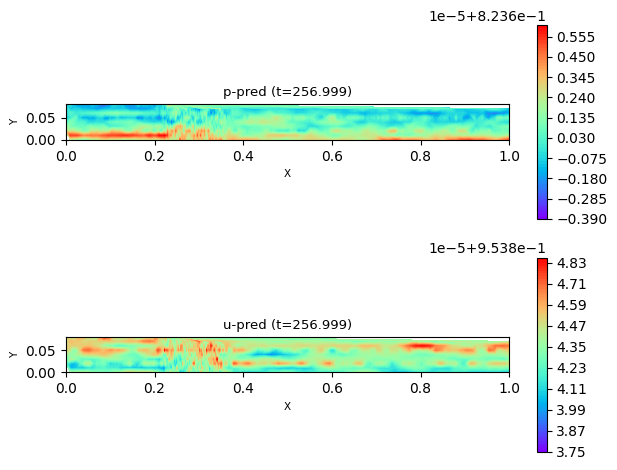

In [54]:
fig, ax = plt.subplots(2, 1)
# Assuming `x`, `y`, and `p_pred` are the x-coordinates, y-coordinates, and predicted pressure values
cntr0 = ax[0].tricontourf(x, y, p_pred, levels=80, cmap="rainbow")

cb0 = plt.colorbar(cntr0, ax=ax[0])
cntr1 = ax[1].tricontourf(x, y, u_pred, levels=80, cmap="rainbow")
cb1 = plt.colorbar(cntr1, ax=ax[1])
ax[0].set_title("p-pred " + "(t=" + str(t) + ")", fontsize=9.5)
ax[0].axis("scaled")
ax[0].set_xlabel("X", fontsize=7.5)
ax[0].set_ylabel("Y", fontsize=7.5)
ax[1].set_title("u-pred " + "(t=" + str(t) + ")", fontsize=9.5)
ax[1].axis("scaled")
ax[1].set_xlabel("X", fontsize=7.5)
ax[1].set_ylabel("Y", fontsize=7.5)
fig.tight_layout()
plt.show()

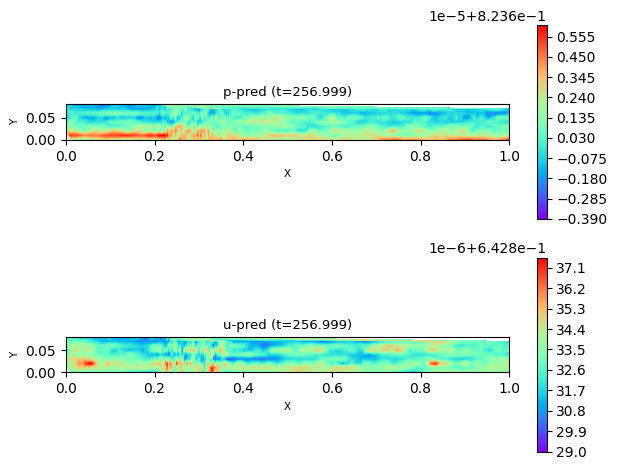

In [55]:
fig, ax = plt.subplots(2, 1)
# Assuming `x`, `y`, and `p_pred` are the x-coordinates, y-coordinates, and predicted pressure values
cntr0 = ax[0].tricontourf(x, y, p_pred, levels=80, cmap="rainbow")

cb0 = plt.colorbar(cntr0, ax=ax[0])
cntr1 = ax[1].tricontourf(x, y, v_pred, levels=80, cmap="rainbow")
cb1 = plt.colorbar(cntr1, ax=ax[1])
ax[0].set_title("p-pred " + "(t=" + str(t) + ")", fontsize=9.5)
ax[0].axis("scaled")
ax[0].set_xlabel("X", fontsize=7.5)
ax[0].set_ylabel("Y", fontsize=7.5)
ax[1].set_title("u-pred " + "(t=" + str(t) + ")", fontsize=9.5)
ax[1].axis("scaled")
ax[1].set_xlabel("X", fontsize=7.5)
ax[1].set_ylabel("Y", fontsize=7.5)
fig.tight_layout()
plt.show()